In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from sklearn.metrics import mean_squared_error
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 導入資料
data = pd.read_csv('/content/drive/MyDrive/作品集_古書瑋/tea_env_data.csv',encoding='utf-8')
# 資料預處理
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['土壤溫度'].values.reshape(-1,1))

In [5]:
# 劃分訓練集和測試集
train_size = int(len(scaled_data) * 0.67)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

In [6]:

def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

look_back = 100
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [7]:

trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], 1)
testX = testX.reshape(testX.shape[0], testX.shape[1], 1)

In [8]:
# 建構Bi-LSTM模型
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(look_back, 1)))
model.add(Bidirectional(LSTM(units=50)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
# 訓練模型
model.fit(trainX, trainY,validation_data=(testX, testY), epochs=40, batch_size=64, verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 448ms/step - loss: 0.0619 - val_loss: 0.0067
Epoch 2/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 267ms/step - loss: 0.0071 - val_loss: 0.0059
Epoch 3/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 256ms/step - loss: 0.0053 - val_loss: 0.0056
Epoch 4/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 332ms/step - loss: 0.0044 - val_loss: 0.0053
Epoch 5/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step - loss: 0.0039 - val_loss: 0.0050
Epoch 6/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 328ms/step - loss: 0.0034 - val_loss: 0.0043
Epoch 7/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 287ms/step - loss: 0.0028 - val_loss: 0.0039
Epoch 8/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 293ms/step - loss: 0.0023 - val_loss: 0.0030
Epoch 9/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 308ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 10/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 322ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 11/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 253ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 12/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 30

In [9]:
# 對測試集進行預測
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


In [10]:

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [11]:
# 計算RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.23 RMSE
Test Score: 0.32 RMSE


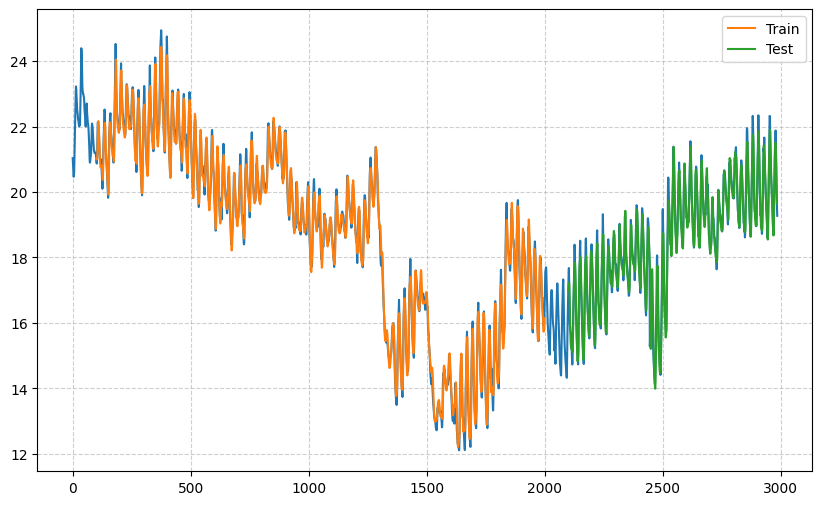

In [12]:
# 畫訓練資料趨勢圖
# shift train predictions for plotting
trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# 畫測試資料趨勢圖
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled_data)-1, :] = testPredict

# 畫原始資料趨勢圖
# plot baseline and predictions
plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(scaled_data))
plt.plot(trainPredictPlot,label='Train')
plt.plot(testPredictPlot,label='Test')
plt.grid(True,linestyle='--',alpha=0.6)
plt.legend()
plt.savefig('TEMP_BiLSTM.png',dpi=100)
plt.show()

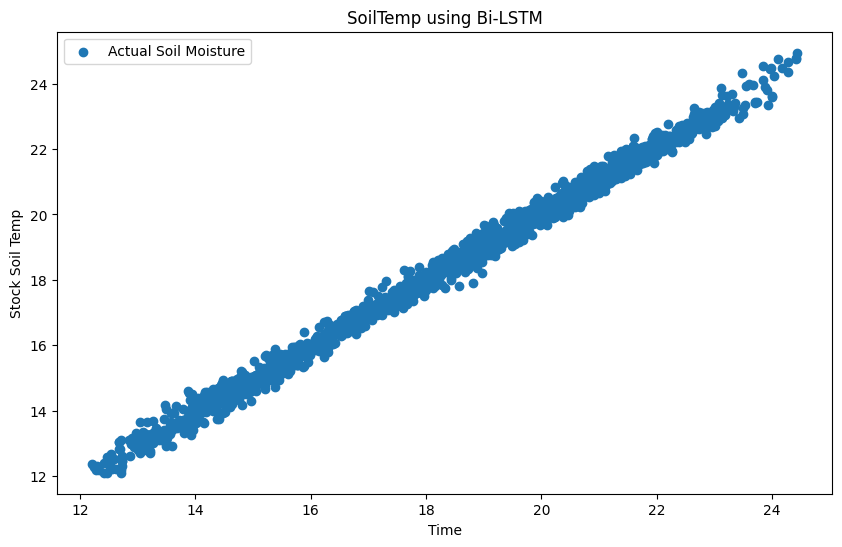

In [13]:
plt.figure(figsize=(10,6))
plt.scatter(trainPredict.flatten(),trainY.flatten(), label='Actual Soil Moisture')
plt.xlabel('Time')
plt.ylabel('Stock Soil Temp')
plt.title('SoilTemp using Bi-LSTM')
plt.legend()
plt.savefig('TEMP_BiLSTM(scatter).png',dpi=100)
plt.show()